<a href="https://colab.research.google.com/github/ebatty/IntroCompNeuro/blob/main/lectures/06_Decoding.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>

# 06 - Decoding
**Learning objectives of lecture/notes**:
After lecture, students should be able to:
- Identify what conclusions you can make about neural populations from decoding stimuli or behavior well
- Identify general steps of model fitting process
- Explain linear decoding model: how the stimulus or behavior is modeled as a function of neural responses

Some of the code/demos are from [Neuromatch W1D3 Model Fitting](https://compneuro.neuromatch.io/tutorials/W1D3_ModelFitting/student/W1D3_Tutorial1.html)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets

# Section 1: Intro to decoding


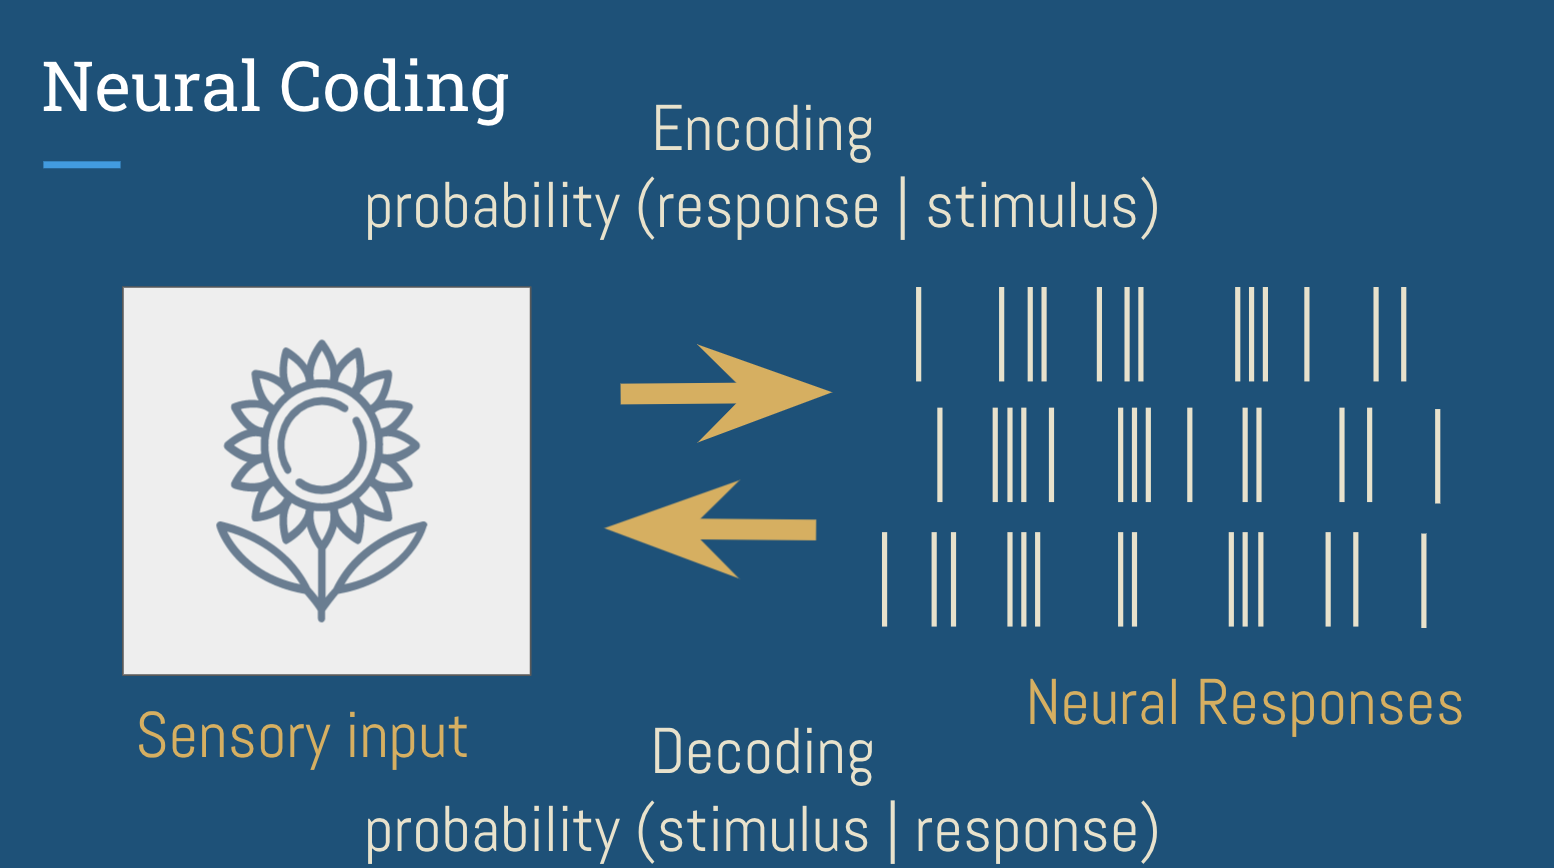

We have been focusing so far on neural encoding: trying to predict the neural response given some stimulus or behavioral variable. We will now turn to the opposite problem. We now want to predict (also called **decode** or **reconstruct**) the stimulus or behavioral variable from the neural responses. 

In neural decoding, we learn some mapping (a model) from the neural responses to the sensory input or behavioral variable from data. We can then use this mapping to predict the experienced sensory input or behavioral variable for new instances of neural responses. There are lots of options for what model to use to map from responses to stimulus/behavior, ranging from quite simple to very complex, deterministic to probabilistic. Later in these notes, we will learn about the most common type of decoding model: linear decoding. 

For now, let's see a few examples of cool decoding to get excited.

## Section 1.1: Examples of decoding

### Example 1: Reconstructing speech from auditory cortex



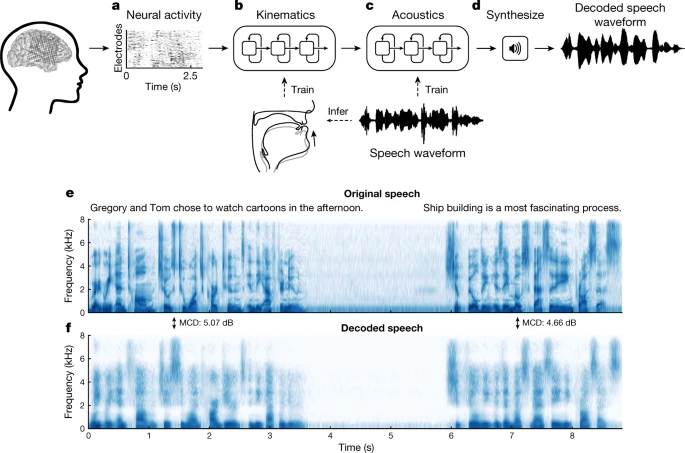


In 2019, Anumanchipalli et al published [a paper](https://www-nature-com.ezp-prod1.hul.harvard.edu/articles/s41586-019-1119-1) in Nature on decoding spoken sentences. 

**Snapshot view:** The researchers recorded neural activity in a human brain while they spoke sentences. They then trained a decoder to go from the neural activity to reconstruct the speech waveform. They got really good performance by creating a unique decoding model: instead of directly decoding the speech waveform, they decoded representations of articulatory movement (the movements of throat/mouth/jaw needed to speak). They then transformed these movements into speech acoustics.  Once they trained this decoding model, they found it was very accurate - participants listening to the decoded speech waveform could identify what the person had said - and even extended to cases where the person mimed speaking but didn't actually produce sound.

**Why do we care:** If we can decode intended speech from brain activity alone, we could build better speech neuroprosthetic technology to restore spoken communication.

### Example 2: Reconstructing faces from fMRI 


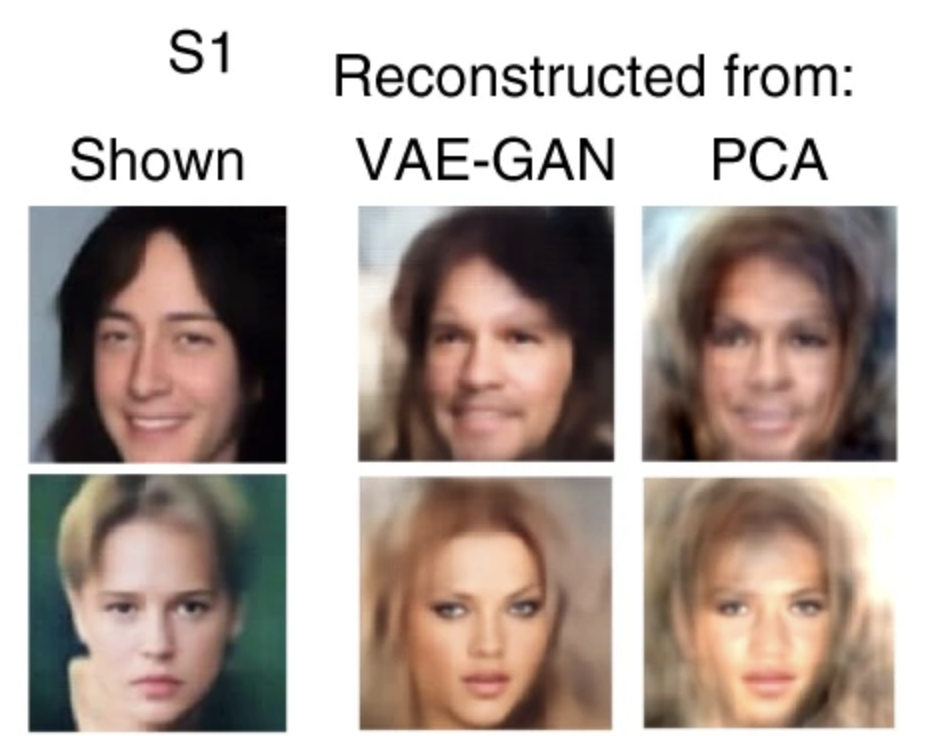


In 2019, VanRullen et al published [a paper](https://www.nature.com/articles/s42003-019-0438-y) on reconstructing faces from fMRI data. 

**Snapshot view:** VanRullen et al presented several thousand faces to humans while using an fMRI to measure brain activity. They then learned a decoding model from the fMRI activation patterns to reconstruct the face presented. To test their decoder, they presented new images to the humans (that they hadn't seen before) and decoded them from the neural activity alone. The decoded faces pretty closely resembled the original ones (see image above - the left column is the presented face, the two right columns are the decoded faces using two different decoding models)!

**Why do we care:** This paper was more of a methods paper showing a new decoding model type that performed well - it didn't use this method to ask and answer scientific questions. Building well performing decoding models/methods is critical for using decoding to understand the brain though! 

## Section 1.2: Why use neural decoding?


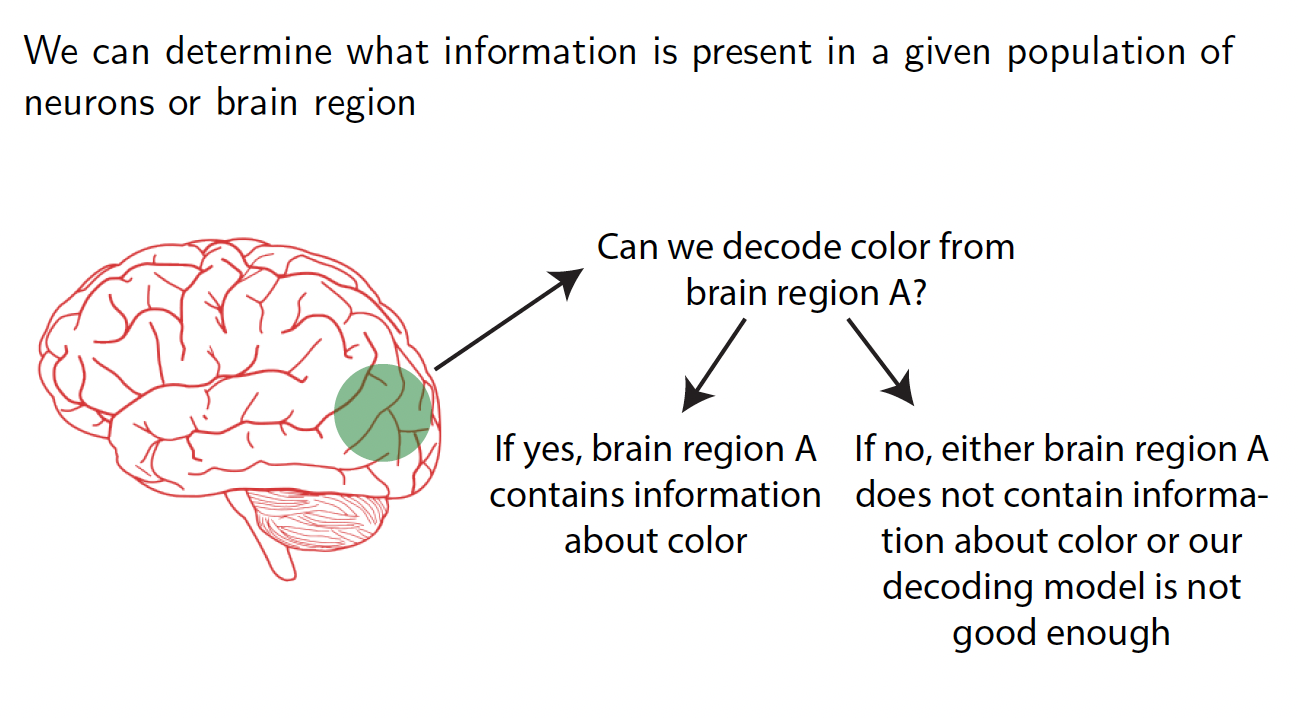

**What can you conclude if you can decode a stimulus or behavioral variable well from a certain group of neurons?**

If we can decode a stimulus or behavioral variable well from a population of neurons, we know that that information is present in the responses of that neural population. We can't conclude that this neural population is important or critical for processing that information or affecting behavior though! We'd to do targeted experiments, like ablating the neural population, to make a stronger conclusion about that.

If we cannot decode the variable of interest, information about that variable may not be present in the neural population. Alternatively, our model could not be sophisticated/good enough to capture that the information is present if it is present in a complex format.

[This paper](https://www.sciencedirect.com/science/article/pii/S0959438818301004?via%3Dihub) is a great opinion piece on interpreting encoding and decoding models. 


**So why use neural decoding if we can't make very strong claims?**

- Neural decoding has a lot of applications! We use neural decoding in neural prosthetics and brain-computer interfaces (to try to predict what a person wants to do just based on their brain signals).
- Even just knowing what information is represented where in the brain is useful. We'll dive more into this in a couple classes.
- You can use **model comparison analysis**. For example, you could decode the stimulus from just one type of neuron and compare to the quality when decoding from another cell type. This could tell you about whether these cell types are representing different information about the stimulus.

# Section 2: Model fitting with linear decoding

In this section, we will outline a common decoding model, linear decoding (also called linear regression more generally), and how to fit this model to data. We'll review the general process of **model fitting **(learning models from data). 

We will use an example where we are trying to decode running speed of a mouse ($s$)from the firing rates of 3 neurons ($n_1, n_2, n_3$). We are ignoring time, so we're treating each time bin as independent and predicting the speed in the bin based only on the neural responses in the same bin. 

## Step 1: Define a mapping (model) from input to output

In order to fit a model to data, we first need to define our model. In other words, we need to define the mapping from input to output with some learnable parameters. 

Here, we will choose a common decoding method: **linear decoding/regression.** In this model, every feature of the stimulus or behavior is decoded as a weighted sum of the neural activity (often plus a constant term).

\begin{align}
s&: \text{value of the running speed}\\
n_1, n_2, n_3 &: \text{firing rates of neuron 1, neuron 2, neuron 3}\\
s &= w_0 + w_1n_1 + w_2n_2 + w_3n_3\\
\end{align}

The weights $w_0$, $w_1$, $w_2$, and $w_3$ are what we need to learn from data. $w_0$ is a constant term: for example in a 1d line, this would be the y-intercept.

We can write this model as a dot product:
$$s = \bar{w}\cdot \bar{n}$$ 
where $\bar{w}$ is the vector of weights and $\bar{n}$ is the vector of neural firing rates plus an additional term of 1 to account for the constant:
$$\bar{w} = \begin{bmatrix}w_0 \\ w_1 \\ w_2 \\ w_3\end{bmatrix},  \bar{n} = \begin{bmatrix}1 \\ n_1 \\ n_2 \\ n_3\end{bmatrix} $$

We now have our model for how the input (neural responses) is transformed to the output (running speed) - we just need to learn our weight values.



## Step 2: Collect data: measurements of input/output pairs

In order to learn the best weights to predict outputs, we need lots of examples of input and output pairs. By input and output pair in this context, I mean the neural responses in a time bin (inputs) and simutaneously recorded mouse running speed (output).  To get lots of data, we can record the neural responses and speed for 10000 time bins. We can use vectors/matrices to store this data:
\begin{align}
\bar{s} = \begin{bmatrix}s \text{ for time bin 1} \\
s \text{ for time bin 2} \\ ...\\ \end{bmatrix}
\end{align}
\begin{align}
N = \begin{bmatrix}n_1 \text{ for time bin 1} & n_2 \text{ for time bin 1} & n_3 \text{ for time bin 1} \\
n_1 \text{ for time bin 2} & n_2 \text{ for time bin 2} & n_3 \text{ for time bin 2} \\
... & ... & ...
 \end{bmatrix}
\end{align}

We can then rewrite our model to account for our multiple data points as:
$$\bar{s} = N\bar{w}$$

Work through the matrix-vector multiplication yourself to convince yourself that this is the same model for each time bin as we wrote earlier with the dot product!

## Step 3: Decide on loss function

We now have our model and the data we want to use to fit it. We need a quantitative measure of how badly our model is doing though - this is called a **cost function**, or **loss function**.  For our linear decoding model, we will use a broadly popular loss function called **mean-squared error**. The mean-squared error is the sum over data points of the difference between true output and predicted output, squared. In equation form:
\begin{align}
\text{Mean squared error (MSE) }&= \sum_{i = 1}^{10000} (s_{\text{time bin i}} - \hat{s}_{\text{time bin i}})^2\\
\end{align}


Here, $\hat{s}_{\text{time bin i}}$  is the predicted value of the speed at time bin i, so:
$$\hat{s}_{\text{time bin i}} = \bar{n}_{\text{time bin i}} \cdot \bar{w}$$


## Step 4: Learn model parameters from data

Now that we have all the necessary components, it's time to actually learn the model parameters from data. There are several different ways of doing this. To take a look at this, we'll simplify our decoding problem even more and decode the running speed based only on the firing rate of one neuron. This is for visualization purposes. We will also drop the constant term, so $$s = w_1*n $$

Execute the cell below to simulate some data and plot it.

 Simulate and plot data


In [ ]:
# @markdown Simulate and plot data
# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence
np.random.seed(121)

# Let's set some parameters
theta = 1.2
n_samples = 30

# Draw x and then calculate y
n = 10 * np.random.rand(n_samples)  # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples)  # sample from a standard normal distribution
s = theta * n + noise

# Plot the results
fig, ax = plt.subplots()
ax.scatter(n, s)  # produces a scatter plot
ax.set(xlabel='neural firing rate (n)', ylabel='running speed (s)');

In the above plot, each data point corresponds to one time bin. It is the neural firing rate and running speed pair for that time bin. In the next cell, I create a function that returns the MSE. 

In [ ]:
def mse(n, s, w1):
  """Compute the mean squared error

  Args:
    n (ndarray): An array of shape (samples,) that contains the input values.
    s (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    w1 (float): An estimate of the slope parameter

  Returns:
    float: The mean squared error of the data with the estimated parameter.
  """

  # Compute the estimated s
  s_hat = w1 * n 

  # Compute mean squared error
  mse = np.mean((s - s_hat)**2)

  return mse

### Option 1: Find best parameters by hand

In our simple example, we want to find the value of $w_1$ that minimizes our mean-squared error (MSE) of our data. We could just try a bunch of different values for $w_1$, compute the MSE, and choose the best value of $w_1$. Try this in the demo below.

 Make sure you execute this cell to enable the widget!


In [ ]:
#@markdown Make sure you execute this cell to enable the widget!

def plot_observed_vs_predicted(n, s, s_hat, w1):
  """ Plot observed vs predicted data

  Args:
    n (ndarray): observed x values
    s (ndarray): observed y values
    s_hat (ndarray): predicted y values
    w1
  """
  fig, ax = plt.subplots()
  ax.scatter(n, s, label='Observed')  # our data scatter plot
  ax.plot(n, s_hat, color='r', label='Fit')  # our estimated model
  # plot residuals
  smin = np.minimum(s, s_hat)
  smax = np.maximum(s, s_hat)
  ax.vlines(n, smin, smax, 'g', alpha=0.5, label='Residuals')
  ax.set(
      title=fr"MSE = {mse(n, s, w1):.2f}",
      xlabel='n',
      ylabel='s'
  )
  ax.legend()

@widgets.interact(w1=widgets.FloatSlider(1.0, min=0.0, max=2.0))
def plot_data_estimate(w1):
  s_hat = w1 * n
  plot_observed_vs_predicted(n, s, s_hat, w1)

The red line in the demo above is the fitted model for the current value of $w_1$. What's the best value of $w_1$? 

Around 1.2 seems to minimize the MSE.

We were able to find this parameter based on the data by hand but this is not a sustainable endeavour. Imagine you were trying to find the weights from even just 3 neurons (let alone thousands) - it would be impossible because you'd have to try a crazy amount of combinations. Luckily, there is an easier way.

### Option 2: Find best parameters by analytical solution
Sometimes, we can find a straight-forward equation for the parameters that minimize the cost function based on the model. It turns out, we get lucky and can do this for linear regression. 

In order to find the analytical solution, we can take the derivative of the loss function with respect to the parameter. We then set this equal to 0, and solve for the parameter. The derivative of the loss function is only 0 at a maximum or minimum (because the tangent line is horizontal there), so this gives us the value of the parameter that results in the maximum or minimum of the function. We should then prove it's a minimum, in which case our equation gives us the parameter values that minimize the loss function. 

I will not go through the derivation but the video below covers it starting at 6 minutes and 50 seconds. The whole video goes through linear regression so may be helpful!

If we do this derivation, we find that the best weight vector is: 

\begin{align}
\bar{w} = (N^TN)^{-1}N^T\bar{s}
\end{align}

This means that we can very easily fit the model by inputting our data into this equation and finding our estimate of $\bar{w}$! This is called the **ordinary least squares solution**.



 Video: Linear Regression


In [ ]:
#@markdown Video: Linear Regression
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="DmoTblsbsCo", width=730, height=410, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Let's use this equation to estimate $w_1$ on our data. Note that it looks a little different in the code because we only have a single parmeter, which changes how some of the vector notation works.

In [ ]:
w1 = (n.T @ n)**-1 * (n.T @ s)
print(w1)

This is pretty close to what we guessed $w_1$ was when we were doing it by hand in Option 1!

### Option 3: Find best parameters by gradient descent

Sometimes, we don't get so lucky and we don't have a nice equation for the parameters that minimize our loss function. In this case, we'll have to find these parameters using alternative methods. One very common method that we'll focus on is called gradient descent. 

The gif below (from Neuromatch W2D1) shows the basic idea of gradient descent.

 Execute this cell to view gradient descent gif


In [ ]:
#@markdown Execute this cell to view gradient descent gif

from IPython.display import Image
Image(url='https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/static/grad_descent.gif?raw=true')


So what's happening here? 

We are looking at a case where we just have a single parameter $w$ for now. This is plotted on the x-axis. The loss function $L(w)$ is on the y-axis. 

We start our gradient descent algorithm by choosing a random value for $w$: $w^0$. We then change this value based on the derivative of the loss function at that value (the gradient). We want to move down further into the valley so we want to step in the negative direction of the slope (so we're heading downhill). We compute this as:
$$w^1 = w^0 - \alpha \frac{dL}{dw^0}$$

Our new guess for the parameter ($w^1$) is the old guess ($w^0$) minus some value $\alpha$ times the derivative of the loss function at that point. We keep doing this iteratively so:
$$w^{i+1} = w^{i} - \alpha \frac{dL}{dw^{i}}$$

If we keep taking small steps, we will eventually get to a minimum, where the derivative will equal 0 so the estimate of $w$ will no longer change, and we'll know to stop. If our loss function is **convex**, there is only one minimum and it is a global minimum. If we take small enough steps, we will always reach that global minimum and find the best parameters with gradient descent. This is why we want convex loss functions!

If our loss function is **non-convex**, there can be local minimums (valleys in the loss function that aren't the absolute minimum value). Depending on the choice of your initial guess, gradient descent could get stuck in a local minimum: we would not find the parameter that leads to the actual minimum of the loss function. 

In [ ]:
# Difficult challenge: implement gradient descent for our example yourself! Otherwise, check
# back here for the implementation after people have a chance to try.

We demonstrated gradient descent with just one parameter, but the idea extends to multiple parameters and a multi-dimensional loss landscape.

## Step 5: Evaluate performance on held-out data

We need to do one last thing in our model fitting procedure. Sometimes, the lowest loss function doesn't actually indicate the best model. Check out the data and model fits (dashed lines below). Image from: https://medium.com/greyatom/what-is-underfitting-and-overfitting-in-machine-learning-and-how-to-deal-with-it-6803a989c76

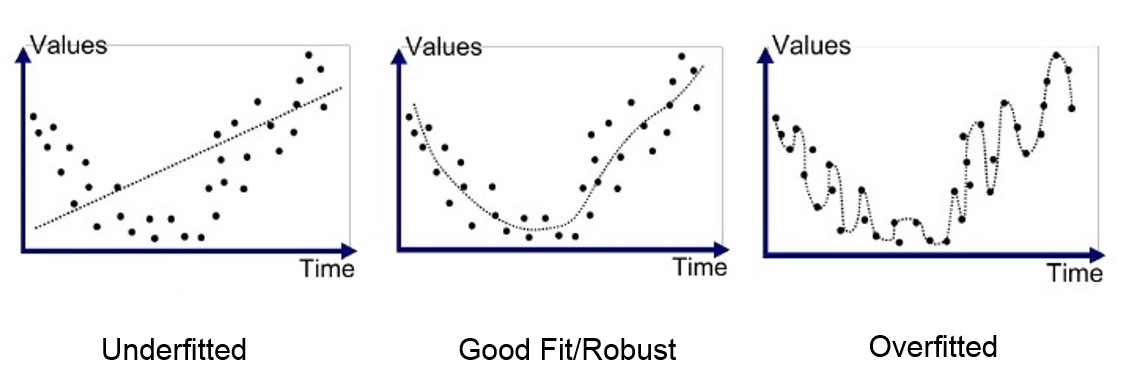

The right-most model fit would lead the lowest MSE. However, it's not a very good model for the data. It is doing something called **overfitting**: it's learned the noise present in the data. This shows that we don't want to just evaluate our model performance on the same data we're using to train it. Instead, we want to evaluate the performance on some held-out data, called test data. These are data points that were not used to find the best parameters (whether by analytical solution or gradient descent).

If we had recorded 10000 time bins of the running speed and neural activity for example, we could use 8000 bins to fit the model (called our **training data**) and 2000 bins to evalute the model (called our **test data**). 

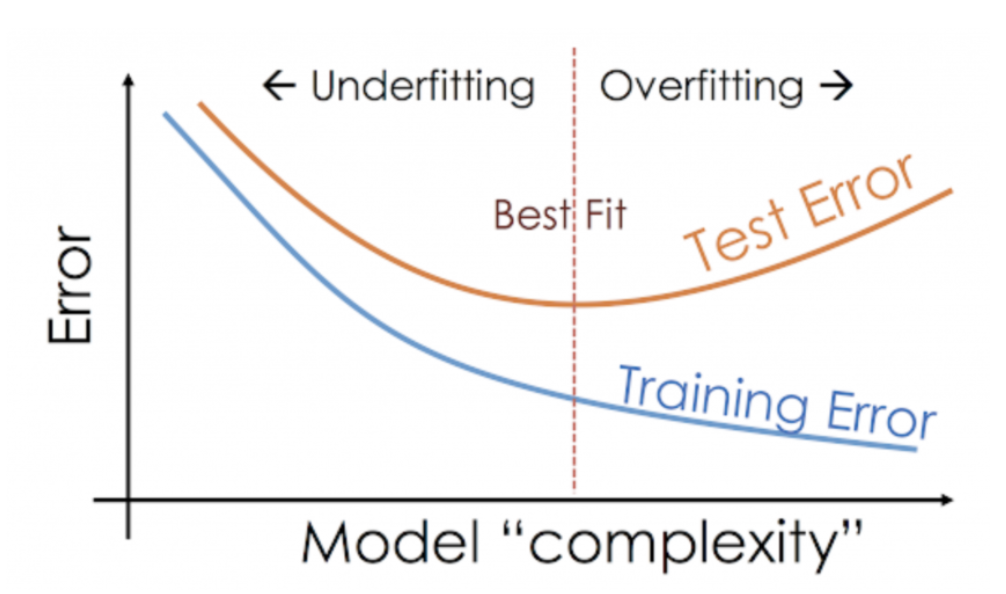

## Model fitting recap & extension

We now have our complete step-by-step process for fitting our model and evaluting how well we're doing! We need our model definition, data, loss function. Then, we learn the model parameters from data, using either an analytical solution or gradient descent, and evaluate how well we're doing on new test data.

We use these steps for fitting all models, including the linear-nonlinear-Poisson encoding models we've discussed previously. There, the loss function was the negative-log-likelihood of the spikes given a Poisson distribution and we have to learn the linear filter using gradient descent.

There's lots more cool stuff to do with fitting models to data - it's a huge field of study that includes machine learning and data science. Going further in-depth is outside the scope of the course but I definitely recommend taking a machine learning or data science course if this kind of thing interests you!


# Section 3: Final thoughts on linear decoding 
We've focused for a bit on procedure of fitting models to data so let's return to our neuroscience focus: decoding. Linear decoding is just one option of a decoding model type, but it is extremely common. It's a simple model that's easy to understand and easy to fit. As with the linear-nonlinear-Poisson models, despite being quite simple, it seems to do a decent job at decoding stimuli and/or behavior in many cases. 

Additionally, there is a scientific reason we might choose this type of model. Remember that we are looking at whether information is present in a neural population. That information would most likely by used (if it is used) by neurons upstream, meaning the neurons that this group projects to. Neurons are great at computing dot products and doing linear transformations of inputs. By using a linear decoding model, we are looking explicitly at whether the information is present in the neural responses in this linearly readable format, that upstream brain regions could figure out. For more explanation of this, see the opinion piece about interpreting neural encoding & decoding models: https://www.sciencedirect.com/science/article/pii/S0959438818301004?via%3Dihub

# Optional readings

- Video on linear regression, with proof of analytical solution:
https://youtu.be/DmoTblsbsCo 

 
- Tutorial on linear regression & model fitting: https://compneuro.neuromatch.io/tutorials/W1D3_ModelFitting/chapter_title.html 

- Tutorial on fitting encoding and decoding models: https://compneuro.neuromatch.io/tutorials/W1D4_GeneralizedLinearModels/chapter_title.html 


- Interesting opinion piece about interpreting neural encoding & decoding models: https://www.sciencedirect.com/science/article/pii/S0959438818301004?via%3Dihub 
